# Training script for training a FasterRCNN to detect mitoses.

    1. Initialising training, validation and test sets for training
    2. Initialising dataloaders
    3. Initialise FasterRCNN
    4. Training lopp
    5. Show some predictions and metrics

## 1. Initialize training, validation and test sets for training

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2



import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy

import IterableSlideDetectionDataset2
from torch.utils.data import DataLoader

from SlideRunner.dataAccess.database import Database
from pathlib import Path
import random

random.seed(42)
torch.cuda.empty_cache()

# Open database
path = Path('wsis/training_dataset_for_mitotic_figure_detection')
wsi_sqlite_file = 'Path to WSI annotations'
database = Database()
database.open(wsi_sqlite_file)
import pickle
# List with meningioma grading test slides
testset = '", "'.join(pickle.load(open('Testset_List.p','rb')))
# Catch all slides from sqlite file
slides = [x[0] for x in database.execute('SELECT uid from Slides where filename not in ("'+testset+'")').fetchall()]
random.shuffle(slides)
# Randomly split splides in trainig, validation and test set for objectdetector training
slidelist_test = slides[0:21]
slidelist_trainval = [x for x in slides if x not in slidelist_test]
slidelist_val = list(map(int,[str(x) for x in slides if x in random.sample(slidelist_trainval,10)]))
slidelist_train = [i for i in slidelist_trainval if i not in slidelist_val]

/home/aubreville/code/SlideRunner/SlideRunner/dataAccess/database.py:2: UserWarning: Deprecated package. Please use the SlideRunner_dataAccess package, and not the SlideRunner main package for data access.
  warnings.warn('Deprecated package. Please use the SlideRunner_dataAccess package, and not the SlideRunner main package for data access.')
/home/aubreville/code/SlideRunner/SlideRunner/dataAccess/annotations.py:2: UserWarning: Deprecated package. Please use the SlideRunner_dataAccess package, and not the SlideRunner main package for data access.
  warnings.warn('Deprecated package. Please use the SlideRunner_dataAccess package, and not the SlideRunner main package for data access.')


## 2. Initialise Dataloaders for Training

In [3]:
# Define transforms for dataloader
transform = transforms.Compose(
    [transforms.ToTensor()])

# Initialize Dataloaders
# The pseudo epoch length defines how many samples are sampled from the train/val set per epoch
val_data = IterableSlideDetectionDataset2.MyIterableSlideDetectionDataset(base_path = path, uids = slidelist_val, database_file = wsi_sqlite_file,pseudo_epoch_length = 500,transforms = transform)
train_data = IterableSlideDetectionDataset2.MyIterableSlideDetectionDataset(base_path = path, uids = slidelist_train, database_file = wsi_sqlite_file, pseudo_epoch_length = 5000,transforms = transform)

[977.0, 648.0, 1024.0, 698.0]


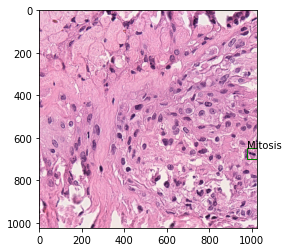

{'boxes': tensor([[ 977.,  648., 1024.,  698.]]), 'labels': tensor([1]), 'difficulties': tensor([0])}


In [5]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt


def imshow(inp,targets,title=None,threshold = None):
    """Imshow for Tensordata."""
    labels = {
        1:'Mitosis'
    }
    inp = inp.numpy().transpose((1, 2, 0))
    w,h,_ = inp.shape
    fig, ax = plt.subplots()
    ax.imshow(inp)

    for idx,(box,label) in enumerate(zip(targets['boxes'],targets['labels'])):
        if threshold != None:
            if targets['scores'][idx] < threshold:
                continue
        box = box.tolist()
        print(box)
        label = label.tolist()
        color = 'r' if labels[label] == 'negative' else 'g'
        box_h = [box[3] - box[1] if box[3] > box[1] else box[1] - box[3]]
        box_w = [box[2] - box[0] if box[2] > box[0] else box[0] - box[2]]
        rect = patches.Rectangle((int(box[0]), int(box[1])), int(box_w[0]), int(box_h[0]), linewidth=1, edgecolor=color, facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(int(box[0]),int(box[1]),labels[label])
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()
    
for image,targets in val_data:
    break
imshow(image,targets)

In [6]:
from torch.utils.data import DataLoader
# Wrap dataloaders in torch dataloader class
val_loader = DataLoader(val_data, batch_size = 16, collate_fn=val_data.collate_fn)
train_loader = DataLoader(train_data, batch_size= 16, collate_fn = val_data.collate_fn)

# Store dataloaders in dict, easier to pass to training function
data_loaders = {
    'train' : train_loader,
    'val' : val_loader,
}

## 3. Initialize FasterRCNN with ResNet18 as backbone

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
resnet18 = torchvision.models.resnet18(pretrained = True)
backbone = nn.Sequential(*(list(resnet18.children())[:-2]))
backbone.out_channels = 512
# Anchor sizes were determined heuristically
anchor_generator = AnchorGenerator(sizes=((307,358,409,460),),aspect_ratios=((1.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# Flange different parts together to form a FasterRCNN model 
model = FasterRCNN(backbone,num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## 4. Define different parts of Training loop

In [8]:
from utils import calculate_mAP
import progressbar

def evaluate(test_loader,model,device):
    ''' evaluate modle output'''
    model.eval()

    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()
    
    with torch.no_grad():
        for images,targets in progressbar.progressbar(val_loader):
            images = list(img.to(device) for img in images)
            output = model(images)

            # Store targets for mAP calculation, one tensor for each image
            target_boxes = [t['boxes'].to(device) for t in targets]
            target_label = [t['labels'].to(device) for t in targets]
            target_difficulties = [t['difficulties'].to(device) for t in targets]

            # Store the predicted labels and boxes
            pred_boxes = [out['boxes'] for out in output]
            pred_label = [out['labels'] for out in output]
            pred_scores = [out['scores'] for out in output]

            det_boxes.extend(pred_boxes)
            det_labels.extend(pred_label)
            det_scores.extend(pred_scores)

            true_boxes.extend(target_boxes)
            true_labels.extend(target_label)
            true_difficulties.extend(target_difficulties)
            
    APs, mAP, cumul_recall, cumul_precision, _, _ = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)
    print('\nMean Average Precision (mAP): %.3f' % mAP)
    return APs
    

In [9]:
import progressbar    

def train_one_epoch(model, optimizer, train_loader, device):
    
    history = {
        'loss_classifier' : list(),
        'loss_box_reg' : list(),
        'loss_objectness' : list(),
        'loss_rpn_box_reg' : list(),
    }
    
    lr_scheduler = None
    pseudo_epoch_length = len(train_loader.dataset)

    model.train()
    
    with progressbar.ProgressBar(max_value=len(train_loader)) as bar:
        for idx,(images,targets) in enumerate(train_loader):
            bar.update(idx)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            history['loss_classifier'].append(loss_dict['loss_classifier'].to('cpu').tolist())
            history['loss_box_reg'].append(loss_dict['loss_box_reg'].to('cpu').tolist())
            history['loss_objectness'].append(loss_dict['loss_objectness'].to('cpu').tolist())
            history['loss_rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].to('cpu').tolist())


            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

            if (idx + 1) % 10 == 0:
                print(f"{idx * len(images)}/{pseudo_epoch_length} Images")
                print(f"loss_classifier: {sum(history['loss_classifier'])/((idx + 1) * len(images)):.5f}, loss_box_reg: {sum(history['loss_box_reg'])/((idx + 1) * len(images)):.5f}")
                print(f"loss_objectness: {sum(history['loss_objectness'])/((idx + 1) * len(images)):.5f}, loss_rpn_box_reg: {sum(history['loss_rpn_box_reg'])/((idx + 1) * len(images)):.5f}")


        
    return history

In [10]:
from matplotlib import pyplot as plt
def plot_metric_logger(metric_logger):
    
    for i in metric_logger.items():    
        plt.plot(metric_logger[i[0]],label = i[0])
        plt.legend()
    plt.xlabel('Batches')
    plt.show()

In [11]:
import copy

def main():
    '''Main Training loop'''
    
    save_path = ""
    
    history = {
        "loss_classifier" : list(),
        "loss_box_reg" : list(),
        "loss_objectness" : list(),
        "loss_rpn_box_reg" : list(),
    }
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'min',factor = 0.1,patience = 10,threshold = 0.01)
    
    num_epochs = 50
    best_mAP = 0.0
    best_model = copy.deepcopy(model.state_dict())

    
    for epoch in range(num_epochs):
        print(f"Epoch{epoch + 1}")
        
        # train for one epoch, printing every 10 iterations
        training_history = train_one_epoch(model, optimizer, train_loader,device, epoch, print_freq = 80)
        # update the learning rate
        
        # evaluate on the test dataset
        #evaluate(model, val_loader, device=device)
        mAP = evaluate(val_loader,model,device)
        lr_scheduler.step(mAP['mitosis'])
        print(f"mAP on Validation Data: {mAP['mitosis']:.2f}")
        for i in history.items():
            history[i[0]].extend(training_history[i[0]])
            
        # Model selection based on validation loss
        if mAP['mitosis'] > best_mAP:
            best_model = copy.deepcopy(model.state_dict())
            best_mAP = mAP['mitosis']
            print(f"best model safed in epoch {epoch}")   
    print("That's it!")
    return history, best_model

In [ ]:
metric_logger,best_model = main()

Epoch1


  2% (9 of 313) |                        | Elapsed Time: 0:04:07 ETA:   2:34:16

144/5000 Images
loss_classifier: 0.00661, loss_box_reg: 0.00010
loss_objectness: 0.02902, loss_rpn_box_reg: 0.02150


  6% (19 of 313) |#                      | Elapsed Time: 0:08:37 ETA:   2:18:22

304/5000 Images
loss_classifier: 0.00444, loss_box_reg: 0.00009
loss_objectness: 0.02268, loss_rpn_box_reg: 0.01835


  9% (29 of 313) |##                     | Elapsed Time: 0:12:59 ETA:   2:25:51

464/5000 Images
loss_classifier: 0.00377, loss_box_reg: 0.00009
loss_objectness: 0.01990, loss_rpn_box_reg: 0.01517


 12% (39 of 313) |##                     | Elapsed Time: 0:17:07 ETA:   1:43:45

624/5000 Images
loss_classifier: 0.00332, loss_box_reg: 0.00009
loss_objectness: 0.01837, loss_rpn_box_reg: 0.01287


 15% (49 of 313) |###                    | Elapsed Time: 0:21:12 ETA:   1:33:50

784/5000 Images
loss_classifier: 0.00297, loss_box_reg: 0.00008
loss_objectness: 0.01749, loss_rpn_box_reg: 0.01157


 18% (59 of 313) |####                   | Elapsed Time: 0:24:59 ETA:   1:37:48

944/5000 Images
loss_classifier: 0.00270, loss_box_reg: 0.00009
loss_objectness: 0.01706, loss_rpn_box_reg: 0.01074


 22% (69 of 313) |#####                  | Elapsed Time: 0:28:59 ETA:   1:41:07

1104/5000 Images
loss_classifier: 0.00244, loss_box_reg: 0.00009
loss_objectness: 0.01662, loss_rpn_box_reg: 0.00991


 25% (79 of 313) |#####                  | Elapsed Time: 0:32:23 ETA:   1:03:10

1264/5000 Images
loss_classifier: 0.00223, loss_box_reg: 0.00009
loss_objectness: 0.01628, loss_rpn_box_reg: 0.00930


 28% (89 of 313) |######                 | Elapsed Time: 0:36:03 ETA:   1:12:34

1424/5000 Images
loss_classifier: 0.00206, loss_box_reg: 0.00009
loss_objectness: 0.01587, loss_rpn_box_reg: 0.00873


 31% (99 of 313) |#######                | Elapsed Time: 0:39:47 ETA:   1:42:15

1584/5000 Images
loss_classifier: 0.00193, loss_box_reg: 0.00009
loss_objectness: 0.01567, loss_rpn_box_reg: 0.00837


 34% (109 of 313) |#######               | Elapsed Time: 0:43:51 ETA:   1:22:54

1744/5000 Images
loss_classifier: 0.00182, loss_box_reg: 0.00009
loss_objectness: 0.01549, loss_rpn_box_reg: 0.00803


 38% (119 of 313) |########              | Elapsed Time: 0:47:20 ETA:   1:03:16

1904/5000 Images
loss_classifier: 0.00173, loss_box_reg: 0.00009
loss_objectness: 0.01530, loss_rpn_box_reg: 0.00775


 41% (129 of 313) |#########             | Elapsed Time: 0:50:22 ETA:   0:57:14

2064/5000 Images
loss_classifier: 0.00166, loss_box_reg: 0.00009
loss_objectness: 0.01521, loss_rpn_box_reg: 0.00763


 44% (139 of 313) |#########             | Elapsed Time: 0:53:31 ETA:   0:41:51

2224/5000 Images
loss_classifier: 0.00160, loss_box_reg: 0.00009
loss_objectness: 0.01503, loss_rpn_box_reg: 0.00741


 47% (149 of 313) |##########            | Elapsed Time: 0:56:46 ETA:   0:51:01

2384/5000 Images
loss_classifier: 0.00154, loss_box_reg: 0.00009
loss_objectness: 0.01494, loss_rpn_box_reg: 0.00723


 50% (159 of 313) |###########           | Elapsed Time: 0:59:49 ETA:   0:34:44

2544/5000 Images
loss_classifier: 0.00149, loss_box_reg: 0.00010
loss_objectness: 0.01483, loss_rpn_box_reg: 0.00701


 53% (169 of 313) |###########           | Elapsed Time: 1:03:11 ETA:   0:37:05

2704/5000 Images
loss_classifier: 0.00145, loss_box_reg: 0.00010
loss_objectness: 0.01473, loss_rpn_box_reg: 0.00683


 57% (179 of 313) |############          | Elapsed Time: 1:06:07 ETA:   0:46:41

2864/5000 Images
loss_classifier: 0.00141, loss_box_reg: 0.00010
loss_objectness: 0.01462, loss_rpn_box_reg: 0.00666


 60% (189 of 313) |#############         | Elapsed Time: 1:08:54 ETA:   0:42:51

3024/5000 Images
loss_classifier: 0.00138, loss_box_reg: 0.00010
loss_objectness: 0.01451, loss_rpn_box_reg: 0.00651


 63% (199 of 313) |#############         | Elapsed Time: 1:11:52 ETA:   0:36:50

3184/5000 Images
loss_classifier: 0.00134, loss_box_reg: 0.00010
loss_objectness: 0.01439, loss_rpn_box_reg: 0.00636


 66% (209 of 313) |##############        | Elapsed Time: 1:14:22 ETA:   0:32:04

3344/5000 Images
loss_classifier: 0.00131, loss_box_reg: 0.00010
loss_objectness: 0.01431, loss_rpn_box_reg: 0.00623


 69% (219 of 313) |###############       | Elapsed Time: 1:16:54 ETA:   0:28:34

3504/5000 Images
loss_classifier: 0.00129, loss_box_reg: 0.00010
loss_objectness: 0.01428, loss_rpn_box_reg: 0.00613


 73% (229 of 313) |################      | Elapsed Time: 1:19:36 ETA:   0:26:22

3664/5000 Images
loss_classifier: 0.00126, loss_box_reg: 0.00010
loss_objectness: 0.01424, loss_rpn_box_reg: 0.00606


 76% (239 of 313) |################      | Elapsed Time: 1:22:01 ETA:   0:10:57

3824/5000 Images
loss_classifier: 0.00125, loss_box_reg: 0.00010
loss_objectness: 0.01417, loss_rpn_box_reg: 0.00597


 79% (249 of 313) |#################     | Elapsed Time: 1:24:40 ETA:   0:17:36

3984/5000 Images
loss_classifier: 0.00122, loss_box_reg: 0.00010
loss_objectness: 0.01412, loss_rpn_box_reg: 0.00587


 82% (259 of 313) |##################    | Elapsed Time: 1:27:17 ETA:   0:15:33

4144/5000 Images
loss_classifier: 0.00120, loss_box_reg: 0.00010
loss_objectness: 0.01407, loss_rpn_box_reg: 0.00579


 85% (269 of 313) |##################    | Elapsed Time: 1:29:37 ETA:   0:14:05

4304/5000 Images
loss_classifier: 0.00119, loss_box_reg: 0.00010
loss_objectness: 0.01404, loss_rpn_box_reg: 0.00571


 89% (279 of 313) |###################   | Elapsed Time: 1:32:19 ETA:   0:11:31

4464/5000 Images
loss_classifier: 0.00117, loss_box_reg: 0.00010
loss_objectness: 0.01397, loss_rpn_box_reg: 0.00562


 92% (289 of 313) |####################  | Elapsed Time: 1:34:33 ETA:   0:06:05

4624/5000 Images
loss_classifier: 0.00116, loss_box_reg: 0.00010
loss_objectness: 0.01392, loss_rpn_box_reg: 0.00554


 95% (299 of 313) |##################### | Elapsed Time: 1:36:46 ETA:   0:03:03

4784/5000 Images
loss_classifier: 0.00114, loss_box_reg: 0.00010
loss_objectness: 0.01386, loss_rpn_box_reg: 0.00548


 98% (309 of 313) |##################### | Elapsed Time: 1:39:02 ETA:   0:00:58

4944/5000 Images
loss_classifier: 0.00113, loss_box_reg: 0.00010
loss_objectness: 0.01383, loss_rpn_box_reg: 0.00542


100% (313 of 313) |######################| Elapsed Time: 1:39:32 Time:  1:39:32
100% (32 of 32) |########################| Elapsed Time: 0:11:58 Time:  0:11:58



Mean Average Precision (mAP): 0.000
mAP on Validation Data: 0.00
Epoch2


  2% (9 of 313) |                        | Elapsed Time: 0:02:03 ETA:   0:48:40

144/5000 Images
loss_classifier: 0.00078, loss_box_reg: 0.00010
loss_objectness: 0.01307, loss_rpn_box_reg: 0.00353


  6% (19 of 313) |#                      | Elapsed Time: 0:04:07 ETA:   1:32:02

304/5000 Images
loss_classifier: 0.00086, loss_box_reg: 0.00014
loss_objectness: 0.01310, loss_rpn_box_reg: 0.00367


  9% (29 of 313) |##                     | Elapsed Time: 0:06:08 ETA:   1:04:57

464/5000 Images
loss_classifier: 0.00084, loss_box_reg: 0.00014
loss_objectness: 0.01272, loss_rpn_box_reg: 0.00352


 12% (39 of 313) |##                     | Elapsed Time: 0:08:08 ETA:   0:48:03

624/5000 Images
loss_classifier: 0.00087, loss_box_reg: 0.00015
loss_objectness: 0.01300, loss_rpn_box_reg: 0.00362


 15% (49 of 313) |###                    | Elapsed Time: 0:10:29 ETA:   0:38:57

784/5000 Images
loss_classifier: 0.00086, loss_box_reg: 0.00014
loss_objectness: 0.01289, loss_rpn_box_reg: 0.00360


 18% (59 of 313) |####                   | Elapsed Time: 0:12:48 ETA:   0:58:33

944/5000 Images
loss_classifier: 0.00084, loss_box_reg: 0.00014
loss_objectness: 0.01279, loss_rpn_box_reg: 0.00353


 22% (69 of 313) |#####                  | Elapsed Time: 0:14:46 ETA:   0:44:26

1104/5000 Images
loss_classifier: 0.00082, loss_box_reg: 0.00014
loss_objectness: 0.01267, loss_rpn_box_reg: 0.00351


 25% (79 of 313) |#####                  | Elapsed Time: 0:16:54 ETA:   0:40:37

1264/5000 Images
loss_classifier: 0.00082, loss_box_reg: 0.00014
loss_objectness: 0.01258, loss_rpn_box_reg: 0.00348


 28% (89 of 313) |######                 | Elapsed Time: 0:19:03 ETA:   0:36:27

1424/5000 Images
loss_classifier: 0.00083, loss_box_reg: 0.00015
loss_objectness: 0.01261, loss_rpn_box_reg: 0.00348


 31% (99 of 313) |#######                | Elapsed Time: 0:21:05 ETA:   0:43:26

1584/5000 Images
loss_classifier: 0.00081, loss_box_reg: 0.00015
loss_objectness: 0.01255, loss_rpn_box_reg: 0.00344


 34% (109 of 313) |#######               | Elapsed Time: 0:23:02 ETA:   0:26:18

1744/5000 Images
loss_classifier: 0.00082, loss_box_reg: 0.00015
loss_objectness: 0.01258, loss_rpn_box_reg: 0.00344


 38% (119 of 313) |########              | Elapsed Time: 0:24:49 ETA:   0:37:51

1904/5000 Images
loss_classifier: 0.00082, loss_box_reg: 0.00015
loss_objectness: 0.01252, loss_rpn_box_reg: 0.00342


 41% (129 of 313) |#########             | Elapsed Time: 0:26:43 ETA:   0:54:12

2064/5000 Images
loss_classifier: 0.00081, loss_box_reg: 0.00016
loss_objectness: 0.01245, loss_rpn_box_reg: 0.00337


 44% (139 of 313) |#########             | Elapsed Time: 0:28:49 ETA:   0:22:16

2224/5000 Images
loss_classifier: 0.00081, loss_box_reg: 0.00016
loss_objectness: 0.01238, loss_rpn_box_reg: 0.00334


 47% (149 of 313) |##########            | Elapsed Time: 0:30:52 ETA:   0:31:06

2384/5000 Images
loss_classifier: 0.00080, loss_box_reg: 0.00016
loss_objectness: 0.01223, loss_rpn_box_reg: 0.00328


 50% (159 of 313) |###########           | Elapsed Time: 0:32:45 ETA:   0:28:48

2544/5000 Images
loss_classifier: 0.00080, loss_box_reg: 0.00016
loss_objectness: 0.01218, loss_rpn_box_reg: 0.00326


 53% (169 of 313) |###########           | Elapsed Time: 0:34:44 ETA:   0:36:23

2704/5000 Images
loss_classifier: 0.00079, loss_box_reg: 0.00016
loss_objectness: 0.01207, loss_rpn_box_reg: 0.00321


 57% (179 of 313) |############          | Elapsed Time: 0:36:13 ETA:   0:26:52

2864/5000 Images
loss_classifier: 0.00079, loss_box_reg: 0.00017
loss_objectness: 0.01204, loss_rpn_box_reg: 0.00318


 60% (189 of 313) |#############         | Elapsed Time: 0:38:14 ETA:   0:13:58

3024/5000 Images
loss_classifier: 0.00079, loss_box_reg: 0.00018
loss_objectness: 0.01200, loss_rpn_box_reg: 0.00317


 63% (199 of 313) |#############         | Elapsed Time: 0:40:06 ETA:   0:19:16

3184/5000 Images
loss_classifier: 0.00078, loss_box_reg: 0.00018
loss_objectness: 0.01192, loss_rpn_box_reg: 0.00317


 66% (209 of 313) |##############        | Elapsed Time: 0:41:53 ETA:   0:11:16

3344/5000 Images
loss_classifier: 0.00077, loss_box_reg: 0.00019
loss_objectness: 0.01185, loss_rpn_box_reg: 0.00317


 69% (219 of 313) |###############       | Elapsed Time: 0:43:41 ETA:   0:26:20

3504/5000 Images
loss_classifier: 0.00077, loss_box_reg: 0.00019
loss_objectness: 0.01180, loss_rpn_box_reg: 0.00315


 73% (229 of 313) |################      | Elapsed Time: 0:45:25 ETA:   0:11:18

3664/5000 Images
loss_classifier: 0.00076, loss_box_reg: 0.00019
loss_objectness: 0.01177, loss_rpn_box_reg: 0.00314


 76% (239 of 313) |################      | Elapsed Time: 0:47:14 ETA:   0:19:00

3824/5000 Images
loss_classifier: 0.00075, loss_box_reg: 0.00019
loss_objectness: 0.01167, loss_rpn_box_reg: 0.00311


 79% (249 of 313) |#################     | Elapsed Time: 0:49:04 ETA:   0:10:53

3984/5000 Images
loss_classifier: 0.00075, loss_box_reg: 0.00019
loss_objectness: 0.01160, loss_rpn_box_reg: 0.00310


 82% (259 of 313) |##################    | Elapsed Time: 0:50:43 ETA:   0:10:11

4144/5000 Images
loss_classifier: 0.00075, loss_box_reg: 0.00020
loss_objectness: 0.01152, loss_rpn_box_reg: 0.00308


 85% (269 of 313) |##################    | Elapsed Time: 0:52:16 ETA:   0:07:20

4304/5000 Images
loss_classifier: 0.00074, loss_box_reg: 0.00021
loss_objectness: 0.01140, loss_rpn_box_reg: 0.00306


 89% (279 of 313) |###################   | Elapsed Time: 0:54:03 ETA:   0:03:39

4464/5000 Images
loss_classifier: 0.00074, loss_box_reg: 0.00022
loss_objectness: 0.01129, loss_rpn_box_reg: 0.00304


 92% (289 of 313) |####################  | Elapsed Time: 0:55:38 ETA:   0:03:22

4624/5000 Images
loss_classifier: 0.00074, loss_box_reg: 0.00022
loss_objectness: 0.01120, loss_rpn_box_reg: 0.00303


 95% (299 of 313) |##################### | Elapsed Time: 0:57:04 ETA:   0:01:45

4784/5000 Images
loss_classifier: 0.00074, loss_box_reg: 0.00023
loss_objectness: 0.01110, loss_rpn_box_reg: 0.00301


 98% (309 of 313) |##################### | Elapsed Time: 0:58:31 ETA:   0:00:20

4944/5000 Images
loss_classifier: 0.00074, loss_box_reg: 0.00024
loss_objectness: 0.01102, loss_rpn_box_reg: 0.00299


100% (313 of 313) |######################| Elapsed Time: 0:59:01 Time:  0:59:01
100% (32 of 32) |########################| Elapsed Time: 0:08:56 Time:  0:08:56



Mean Average Precision (mAP): 0.179
mAP on Validation Data: 0.18
best model safed in epoch 1
Epoch3


  2% (9 of 313) |                        | Elapsed Time: 0:01:19 ETA:   0:54:15

144/5000 Images
loss_classifier: 0.00079, loss_box_reg: 0.00066
loss_objectness: 0.00732, loss_rpn_box_reg: 0.00206


  6% (19 of 313) |#                      | Elapsed Time: 0:02:56 ETA:   0:50:31

304/5000 Images
loss_classifier: 0.00071, loss_box_reg: 0.00060
loss_objectness: 0.00698, loss_rpn_box_reg: 0.00210


  9% (29 of 313) |##                     | Elapsed Time: 0:04:20 ETA:   0:20:24

464/5000 Images
loss_classifier: 0.00070, loss_box_reg: 0.00059
loss_objectness: 0.00710, loss_rpn_box_reg: 0.00219


 12% (39 of 313) |##                     | Elapsed Time: 0:06:12 ETA:   0:30:00

624/5000 Images
loss_classifier: 0.00069, loss_box_reg: 0.00054
loss_objectness: 0.00710, loss_rpn_box_reg: 0.00260


 15% (49 of 313) |###                    | Elapsed Time: 0:07:42 ETA:   0:44:41

784/5000 Images
loss_classifier: 0.00067, loss_box_reg: 0.00053
loss_objectness: 0.00700, loss_rpn_box_reg: 0.00258


 18% (59 of 313) |####                   | Elapsed Time: 0:09:22 ETA:   0:55:15

944/5000 Images
loss_classifier: 0.00067, loss_box_reg: 0.00053
loss_objectness: 0.00688, loss_rpn_box_reg: 0.00251


 20% (63 of 313) |####                   | Elapsed Time: 0:10:02 ETA:   0:22:52

In [ ]:
model.load_state_dict(best_model)
torch.save(model.state_dict(), "FasterRCNN.pth")

## 5. Show some predictions and metrics

In [ ]:
import matplotlib.pyplot as plt

def show_predictions_batch(images,outputs,targets,threshold = None):
    '''Funktion that shows prediktions and labels on images'''
    plt.rcParams['figure.figsize'] = [5, 5]

    fig,ax_grid = plt.subplots(int(len(images)/2),2,figsize=(15,15))
    ax_grid = ax_grid.flatten()
    for idx,(img,out,target) in enumerate(zip(images,outputs,targets)):
        img = img.numpy().transpose((1, 2, 0))
        w,h,_ = img.shape

        ax_grid[idx].imshow(img)
        ax_grid[idx].axis('off')


        for i,(box,label) in enumerate(zip(out['boxes'],out['labels'])):
            if threshold != None:
                if out['scores'][i] < threshold:
                    continue
            box = box.tolist()
            label = label.tolist()
            color = 'r' if labels[label] == 'negative' else 'g'
            box_h = [box[3] - box[1] if box[3] > box[1] else box[1] - box[3]]
            box_w = [box[2] - box[0] if box[2] > box[0] else box[0] - box[2]]
            rect = patches.Rectangle((int(box[0]), int(box[1])), int(box_w[0]), int(box_h[0]), linewidth=1, edgecolor=color, facecolor='none')
            # Add the patch to the Axes
            ax_grid[idx].add_patch(rect)
            ax_grid[idx].text(int(box[0]),int(box[1]),labels[label])

        for box,label in zip(target['boxes'],target['labels']):

            box = box.tolist()
            box_h = [box[3] - box[1] if box[3] > box[1] else box[1] - box[3]]
            box_w = [box[2] - box[0] if box[2] > box[0] else box[0] - box[2]]
            rect = patches.Rectangle((int(box[0]), int(box[1])), int(box_w[0]), int(box_h[0]), linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax_grid[idx].add_patch(rect)

    plt.show()

In [ ]:
# bring model to evaluation mode
model.loadt_state_dict(best_model)
model.eval()
device = torch.device('cuda')

In [ ]:
# get one batch 
for images, targets in val_loader.__iter__():
    break
with torch.no_grad():
    # bring batch to gpu
    images = list(img.to(device) for img in images)
    # detect batch
    outputs = model(images)

boxes = list()
label_list = list()
scores_list = list()
# bring outputs to cpu
for idx,out in enumerate(outputs):
    outputs[idx]['boxes'] = out['boxes'].to('cpu')
    outputs[idx]['labels'] = out['labels'].to('cpu')
    outputs[idx]['scores'] = out['scores'].to('cpu')

images = list(image.to('cpu') for image in images)
# show detections
show_predictions_batch(images,outputs,targets,0.3)

In [ ]:
mAP,cumul_recall,cumul_precision, APs = evaluate(val_loader,model,device)

In [ ]:
cumul_recall = cumul_recall.to('cpu').numpy()
cumul_precision = cumul_precision.to('cpu').numpy()

In [ ]:
plt.plot(cumul_recall,cumul_precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('mAP Mitosis: {:.4f}'.format(mAP))